In [16]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF Function
def calculate_vif(df, thresh=10.0):
    variables = df.columns.tolist()
    dropped = []

    while True:
        vif = pd.DataFrame()
        vif["Feature"] = variables
        vif["VIF"] = [variance_inflation_factor(df[variables].values, i) for i in range(len(variables))]
        
        max_vif = vif["VIF"].max()
        if max_vif > thresh:
            max_feature = vif.loc[vif["VIF"] == max_vif, "Feature"].values[0]
            print(f"Dropping '{max_feature}' with VIF = {max_vif:.2e}")
            variables.remove(max_feature)
            dropped.append(max_feature)
        else:
            break

    print("\nFinal Features with Acceptable VIF:")
    print(vif[vif["VIF"] <= thresh].sort_values("VIF"))
    return df[variables], dropped


In [17]:
# Load and inspect dataset
df = pd.read_csv("american_bankruptcy.csv")
df = df.drop('X16', axis=1)

# Normalize financial variables by total assets (X10)
cols = df.columns.difference(["company_name", "status_label", "year"])
df[cols] = df[cols].div(df['X10'], axis=0)

# Drop rows with missing/inf values after normalization (if any)
df = df.replace([np.inf, -np.inf], np.nan).dropna()


In [18]:
# Define features and target
X = df.drop(columns=["status_label", "company_name", "year"])
y = df["status_label"].map({'alive': 0, 'failed': 1})  # Binary encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)


In [19]:
df = df.drop('X16', axis=1)

KeyError: "['X16'] not found in axis"

Dropping 'X18' with VIF = 1.39e+13
Dropping 'X12' with VIF = 3.68e+08
Dropping 'X2' with VIF = 3.37e+08
Dropping 'X17' with VIF = 2.72e+01

Final Features with Acceptable VIF:
   Feature       VIF
6       X8  1.060615
3       X5  1.148096
5       X7  1.181734
9      X11  1.272901
0       X1  1.294215
1       X3  1.458830
7       X9  1.545255
12     X15  2.996055
10     X13  3.035531
11     X14  3.413226
8      X10  5.128567
4       X6  5.283162
2       X4  7.780141


LogisticRegression(max_iter=1000)


Feature Coefficients:
   Feature  Coefficient
3       X5     1.312996
8      X10     0.220483
7       X9     0.025663
4       X6     0.003857
9      X11     0.003438
10     X13     0.002056
12     X15     0.000090
6       X8    -0.002616
1       X3    -0.003194
11     X14    -0.003881
2       X4    -0.011546
0       X1    -0.968703
5       X7    -1.032657

Model Accuracy: 0.5121052297134142
Precision: 0.08271340310175261
Recall: 0.619452313503305
F1 Score: 0.14593993325917687

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.66     14678
           1       0.08      0.62      0.15      1059

    accuracy                           0.51     15737
   macro avg       0.52      0.56      0.40     15737
weighted avg       0.89      0.51      0.62     15737



<Figure size 500x400 with 0 Axes>

<Axes: >

Text(0.5, 14.722222222222216, 'Predicted')

Text(33.22222222222222, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

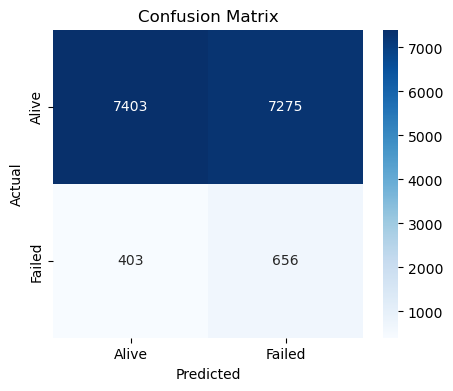

In [20]:
# VIF filtering BEFORE SMOTE
X_train_vif, dropped_cols = calculate_vif(X_train, thresh=10.0)
X_test_vif = X_test.drop(columns=dropped_cols)

# Apply SMOTE on VIF-cleaned training data
smote = SMOTE(sampling_strategy='auto', random_state=99)
X_train_sm, y_train_sm = smote.fit_resample(X_train_vif, y_train)

# Fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_sm, y_train_sm)

# Coefficients
coef_df = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "Coefficient": logreg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Coefficients:")
print(coef_df)

# Predictions and Evaluation
y_pred = logreg.predict(X_test_vif)

print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Alive", "Failed"], yticklabels=["Alive", "Failed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
